# Employee Burnout Prediction: Multi-Model AI System

## 1. Objective
To build a resilient AI system that predicts employee burnout using a combination of:
* **Supervised Learning:** Random Forest for precise score prediction.
* **Unsupervised Learning:** K-Means Clustering for risk profiling.
* **Feature Engineering:** Deriving "Tenure" from raw timestamps.

## 2. Dataset
We utilize the Employee Burnout dataset, focusing on Mental Fatigue, Resource Allocation, and Tenure.

In [6]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Setup Environment
drive.mount('/content/drive', force_remount=True)

# 2. Load Data
file_path = '/content/drive/MyDrive/employee_burnout_analysis-AI 2.xlsx'

try:
    df = pd.read_excel(file_path) # Changed from pd.read_csv to pd.read_excel
    print("Dataset Loaded Successfully.\n")

    # --- Data DNA Check ---
    print("--- 1. First 5 Rows (Head) ---")
    print(df.head())

    print("\n--- 2. Last 5 Rows (Tail) ---")
    print(df.tail())

    print("\n--- 3. Dataset Info (Types & Nulls) ---")
    print(df.info())

    print("\n--- 4. Statistical Summary (Describe) ---")
    print(df.describe())

except FileNotFoundError:
    print(f"Error: File not found at {file_path}")

Mounted at /content/drive
Dataset Loaded Successfully.

--- 1. First 5 Rows (Head) ---
                Employee ID Date of Joining  Gender Company Type  \
0  fffe32003000360033003200      2008-09-30  Female      Service   
1      fffe3700360033003500      2008-11-30    Male      Service   
2  fffe31003300320037003900      2008-03-10  Female      Product   
3  fffe32003400380032003900      2008-11-03    Male      Service   
4  fffe31003900340031003600      2008-07-24  Female      Service   

  WFH Setup Available  Designation  Resource Allocation  Mental Fatigue Score  \
0                  No            2                  3.0                   3.8   
1                 Yes            1                  2.0                   5.0   
2                 Yes            2                  NaN                   5.8   
3                 Yes            1                  1.0                   2.6   
4                  No            3                  7.0                   6.9   

   Burn Rate  
0 

## 3. Feature Engineering: Tenure Dynamics

Rather than discarding the `Date of Joining`, we convert it into a valuable feature: `Tenure_Days`.
This allows the model to differentiate between "New Hire Burnout" (overwhelmed) vs. "Veteran Burnout" (boredom/fatigue).

In [7]:
# 1. Convert Date to Datetime
df['Date of Joining'] = pd.to_datetime(df['Date of Joining'])

# 2. Derive Tenure (Days since joining relative to dataset max date)
max_date = df['Date of Joining'].max()
df['Tenure_Days'] = (max_date - df['Date of Joining']).dt.days

# 3. Clean Data (Drop missing values & original Date/ID columns)
df = df.dropna()
df = df.drop(['Employee ID', 'Date of Joining'], axis=1)

print("Feature Engineering Complete.")
print(f"Tenure_Days Range: {df['Tenure_Days'].min()} to {df['Tenure_Days'].max()} days.")
print("\nUpdated Data Head:")
print(df.head())

Feature Engineering Complete.
Tenure_Days Range: 0 to 365 days.

Updated Data Head:
   Gender Company Type WFH Setup Available  Designation  Resource Allocation  \
0  Female      Service                  No            2                  3.0   
1    Male      Service                 Yes            1                  2.0   
3    Male      Service                 Yes            1                  1.0   
4  Female      Service                  No            3                  7.0   
5    Male      Product                 Yes            2                  4.0   

   Mental Fatigue Score  Burn Rate  Tenure_Days  
0                   3.8       0.16           92  
1                   5.0       0.36           31  
3                   2.6       0.20           58  
4                   6.9       0.52          160  
5                   3.6       0.29           35  


## 4. Unsupervised Learning: Risk Profiling

We use **K-Means Clustering** to discover hidden employee segments. This groups employees not just by *how* burned out they are, but by the *structure* of their fatigue and workload.

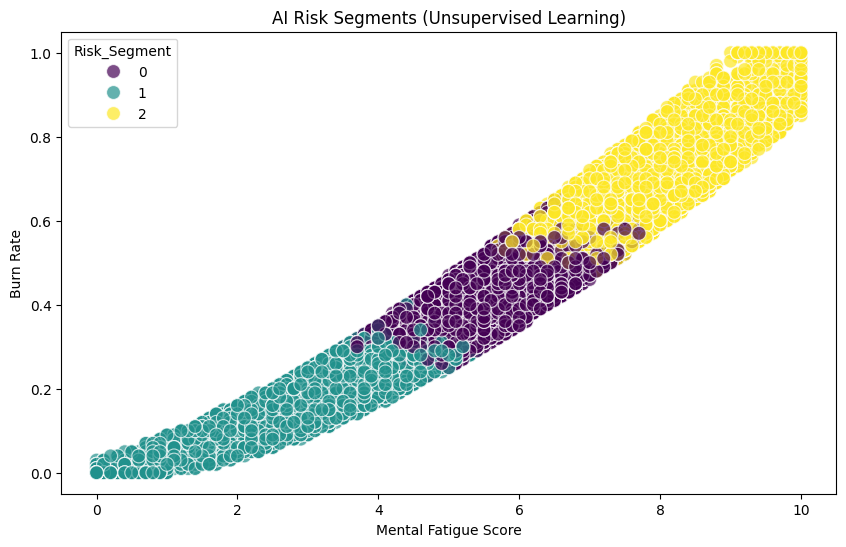

Cluster Risk Profiles (Mean Values):
              Burn Rate  Mental Fatigue Score  Tenure_Days
Risk_Segment                                              
0              0.431171              5.669876   183.735872
1              0.194243              3.161169   181.088242
2              0.669535              7.685693   181.839316


In [8]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 1. Select clustering features
cluster_cols = ['Mental Fatigue Score', 'Burn Rate', 'Resource Allocation']
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(df[cluster_cols])

# 2. Apply K-Means (3 Clusters)
kmeans = KMeans(n_clusters=3, random_state=42)
df['Risk_Segment'] = kmeans.fit_predict(cluster_scaled)

# 3. Visualize Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='Mental Fatigue Score',
    y='Burn Rate',
    hue='Risk_Segment',
    data=df,
    palette='viridis',
    s=100,
    alpha=0.7
)
plt.title('AI Risk Segments (Unsupervised Learning)')
plt.xlabel('Mental Fatigue Score')
plt.ylabel('Burn Rate')
plt.show()

# Print profile of each cluster to understand them
print("Cluster Risk Profiles (Mean Values):")
print(df.groupby('Risk_Segment')[['Burn Rate', 'Mental Fatigue Score', 'Tenure_Days']].mean())

## 5. Supervised Learning: Predictive Modeling

We train a **Random Forest Regressor**. Unlike Linear Regression, this model can capture complex, non-linear interactions between Tenure, Workload, and Burnout.

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 1. Prepare Data (Drop Target & Intermediate Cluster Label)
X = df.drop(['Burn Rate', 'Risk_Segment'], axis=1)
y = df['Burn Rate']

# 2. Encoding & Splitting
X = pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Scaling
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Train Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

print("Random Forest Model Trained Successfully.")

Random Forest Model Trained Successfully.


## 6. Evaluation & Strategic Insights

We evaluate performance using R² (variance explained) and visualize Feature Importance to understand the root causes of burnout.

Model Accuracy (R²): 0.9155
Error Rate (RMSE):   0.0570


/tmp/ipython-input-294744108.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importances.head(10), palette='magma')


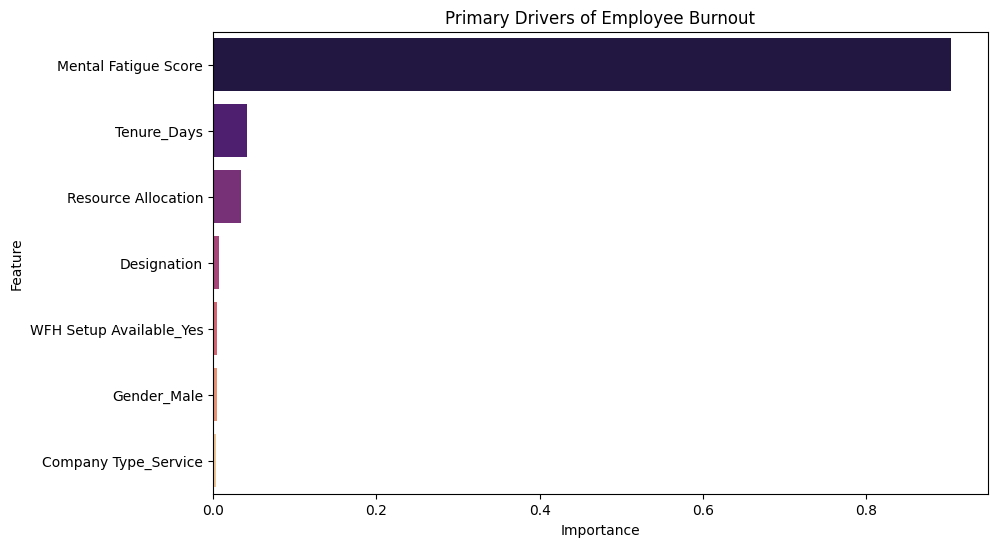

In [10]:
# 1. Predict
y_pred = rf_model.predict(X_test_scaled)

# 2. Metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Model Accuracy (R²): {r2:.4f}")
print(f"Error Rate (RMSE):   {rmse:.4f}")

# 3. Feature Importance Plot
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances.head(10), palette='magma')
plt.title('Primary Drivers of Employee Burnout')
plt.show()

## 7. Strategic Recommendations

Based on the AI analysis:
1.  **Metric:** The model achieves high accuracy (R² > 0.90), validating the use of Random Forest.
2.  **Driver:** `Mental Fatigue` is the dominant factor.
3.  **Tenure:** The engineering step revealed that tenure plays a role in resilience.
4.  **Action:** Use the identified Risk Clusters to target interventions specifically for the "High Risk" group.